In [89]:
# Python imports

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
# Capstone imports

import sys
sys.path.append('../')
import wrangle

In [3]:
# Get wrangle file

wdf = wrangle.wrangle_data()
wdf

,q00,q01a,q01b,q01c,q02a,q02b,q02c,q02d,q02e,q02f,...,q15,q16,q17a,q17b,q18a,q21,q22,q23,q09a,persona_id
0,284,Academic,4,1.0,3,2,0,3,3,3,...,NaN,"CHI, INTERACT",depending on the professional values,7.0,"any, depending on the values",research-practice connections,NaN,research-practice connections,"sort of, psychology background.",2
1,288,Academic,4,1.0,1,2,1,3,3,3,...,"Dagstuhl workshop - small, intense, intimate g...",Hawaii international conference on Education,I would attend any of these,6.0,Multi-track: Every attendee chooses their own ...,NaN,NaN,Don’t create schedule conflicts with other rel...,"Yes, I was taught how to conduct research",2
2,294,Academic,4,1.0,3,3,1,3,1,3,...,Courses at Copenhagen University (deep knowle...,"Research Tuesdays (Czech), UX/Design Conferen...",It depends - I really enjoyed small conference...,7.0,It depends,NaN,NaN,Looking forward! \n,"Yes, I was taught how to conduct research",2
3,281,Academic,4,1.0,3,4,0,2,3,2,...,A workshop at the Society for Applied Anthropo...,A local education implementation conference.,Large conference: 500+ attendees,4.0,Multi-track: Every attendee chooses their own ...,"Research design, innovative methods, communica...",NaN,NaN,"Yes, I was taught how to conduct research",2
4,280,Academic,4,1.0,3,3,0,1,1,3,...,NaN,NaN,Large conference: 500+ attendees,4.0,Multi-track: Every attendee chooses their own ...,NaN,NaN,NaN,"No, I was not taught how to conduct research",2
5,295,Academic,4,1.0,3,4,1,3,1,3,...,"IA summit: High quality talks, enthusiastic co...","IA Summit, ASIST",Mid-size conference : 300-500 attendees,3.0,Multi-track: Every attendee chooses their own ...,NaN,"I like a mix, academics and professionals, qua...",I actually feel like the biggest contribution ...,"Yes, I was taught how to conduct research",2
6,291,Academic,4,1.0,3,3,0,3,3,3,...,Academic conferences \n,"Marketing and design, technology management, i...",Mid-size conference : 300-500 attendees,3.0,Multi-track: Every attendee chooses their own ...,"design, participatory analysis,","companies, academic researchers, public policy...",NaN,"No, I was not taught how to conduct research",2
7,290,Academic,4,1.0,3,3,1,3,4,4,...,A research stay in a leading University,"Seminars in different universities: UCLA, UPF,...",Mid-size conference : 300-500 attendees,3.0,Multi-track: Every attendee chooses their own ...,Sessions about new methodologies or cases studies,Leading researchers,Go ahead! Your prestige is a guaranty,"Yes, I was taught how to conduct research",2
8,296,Academic,4,1.0,3,3,0,3,1,3,...,Small conference on research on mass transit. ...,Session at Society for Applied Anth conference...,Retreat/workshop: < 50 attendees,1.0,Single-track: All attendees experience the sam...,Sampling and participant recruitment; Strategi...,People who are known to have developed skill s...,It would be nice to have more conferences that...,"Yes, I was taught how to conduct research",2
9,279,Academic,4,1.0,3,3,0,3,0,2,...,NaN,NaN,Retreat/workshop: < 50 attendees,1.0,Multi-track: Every attendee chooses their own ...,Sharing of methods or best practices.,NaN,NaN,"No, I was not taught how to conduct research",2


In [4]:
wdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 73 columns):
q00           868 non-null int64
q01a          868 non-null object
q01b          868 non-null int64
q01c          865 non-null float64
q02a          868 non-null int64
q02b          868 non-null int64
q02c          868 non-null int64
q02d          868 non-null int64
q02e          868 non-null int64
q02f          868 non-null int64
q02g          868 non-null int64
q02h          868 non-null int64
q02i          868 non-null int64
q02j          868 non-null int64
q03           865 non-null float64
q04           862 non-null float64
q08a          824 non-null float64
q08b          824 non-null float64
q08c          824 non-null float64
q08d          824 non-null float64
q08e          824 non-null float64
q08f          824 non-null float64
q08g          824 non-null float64
q08h          824 non-null float64
q08i          824 non-null float64
q08j          824 non-null float64
q11a      

## Mixed Questions

### Q09
***Did any part of your education include learning about how to conduct research?***

In [5]:
q09df = wdf[['q09a']].copy()
display(q09df.head())
display(q09df.info())

,q09a
0,"sort of, psychology background."
1,"Yes, I was taught how to conduct research"
2,"Yes, I was taught how to conduct research"
3,"Yes, I was taught how to conduct research"
4,"No, I was not taught how to conduct research"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 1 columns):
q09a    824 non-null object
dtypes: object(1)
memory usage: 6.9+ KB


None

In [58]:
q09vc = pd.DataFrame(q09df.q09a.value_counts(dropna=False)).rename(columns={'q09a':'q09vc'})
q09vc.index.name = 'q09v'

In [53]:
q09vc[q09vc.q09vc>5]

,q09vc
q09v,
"Yes, I was taught how to conduct research",577
"No, I was not taught how to conduct research",194
NaN,44


In [7]:
q09a_cats = {
    "Yes, I was taught how to conduct research ": 1,
    "No, I was not taught how to conduct research": 2,
#     "": ,
#     "": ,
}

In [54]:
q09vc[q09vc.q09vc<5]

,q09vc
q09v,
University studies in sociological / statistical methods,1
kindof...I had one research class in design school,1
"none of my education had anything to do with research, i found myself in a design research internship and learned on the job",1
As a small part of my design education.,1
"I was formally trained as a design, which had research teachings, but as for qualitative research my learning has been sourced from on the job researcher mentors, conferences and my own self-guided study of methodology.",1
self taught and mentored,1
"Yes, but a minimal amount",1
"I'm largely self-taught, so yes, but there is plenty to learn",1
"Education taught some aspects, but I didn't focus on it",1


### Q17
***What would be the ideal audience size for a conference about research that *you* would want to attend?!***

In [8]:
q17df = wdf[['q17a', 'q17b']].copy()
display(q17df.head())
display(q17df.info())

,q17a,q17b
0,depending on the professional values,7.0
1,I would attend any of these,6.0
2,It depends - I really enjoyed small conference...,7.0
3,Large conference: 500+ attendees,4.0
4,Large conference: 500+ attendees,4.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 2 columns):
q17a    737 non-null object
q17b    866 non-null float64
dtypes: float64(1), object(1)
memory usage: 13.6+ KB


None

In [50]:
q17vc = pd.DataFrame(q17df.q17a.value_counts(dropna=False)).rename(columns={'q17a':'q17vc'})
q17vc.index.name = 'q17v'

In [51]:
q17vc[q17vc.q17vc>5]

,q17vc
q17v,
Small conference: < 300 attendees,259
Retreat/workshop: < 50 attendees,193
Mid-size conference : 300-500 attendees,178
NaN,131
Large conference: 500+ attendees,45


In [10]:
q17a_cats = {
    "Retreat/workshop: < 50 attendees": 1,
    "Small conference: < 300 attendees ": 2,
    "Mid-size conference : 300-500 attendees": 3,
    "Large conference: 500+ attendees": 4,
    "Other": 5,
}

In [52]:
q17vc[q17vc.q17vc<5]

,q17vc
q17v,
it doesn't matter,2
No preference,2
Depends on what I want to learn and how intensely,1
Not a variable that would affect my decision,1
I don't mind at all,1
"It depends - I really enjoyed small conferences as IXDA Education Summit as there is great opportunity to network with other educators. On the other side, sometimes is great just to attend big conference to find an inspiration or just to meet coll...",1
Any size,1
"Using teleconference tech, so 1 person",1
open to any of the above; depends on the format/contennt etc,1


In [83]:
q17bgb = q17df.groupby(by=['q17b','q17a']).count()

In [81]:
q17bgb 

Empty DataFrame
Columns: []
Index: [(1.0, Class), (1.0, Retreat/workshop: < 50 attendees), (2.0, 150), (2.0, 50-300 attendees), (2.0, <100), (2.0, I like to 100-120 number most; intimacy and time to dwell on 'stranger things'), (2.0, Small conference: < 300 attendees), (3.0, Mid-size conference : 300-500 attendees), (3.0, Retreat to mid-size are all appealing), (3.0, To be honest, I'm not sure I have one single ideal audience size but im not a fan of overly large, commercialized conferences.... So mostly smaller conferences and workshops are best when I'm trying to deepens my knowledge on a specific methodology), (4.0, 500-750), (4.0, Large conference: 500+ attendees), (6.0, All of these are fine. I can learn in all if them if the courses are constructed to match the size and venue.), (6.0, Any of the above), (6.0, Any size), (6.0, Any size, not fussed), (6.0, Audience size doesn't matter), (6.0, Doesn't matter?), (6.0, Don't matter the size), (6.0, Don’t have a preference), (6.0, I don't care about the size), (6.0, I don't care as long as I actually learn something. Not intro content.), (6.0, I don't consider this an important factor), (6.0, I don't mind at all), (6.0, I don't really think size is a decisive factor... I can imagine amazing event in small and also in large scale), (6.0, I honestly don't care about size comparative to contenr), (6.0, I really don’t have a preference), (6.0, I will consider any size of conference), (6.0, I would attend any of these), (6.0, I'm not sure that number of attendees would be an influencing factor - other factors are more important to me), (6.0, I'm open to anything. I like the small retreats and small conferences for their intimacy but sometimes I want the options of a large conference.), (6.0, It doesn’t matter, content is the king ), (6.0, It is not important the size), (6.0, No preference), (6.0, Not a variable that would affect my decision), (6.0, Number of people isn't my only consideration it's mainly location and cost. I would be happy with all of the above.), (6.0, Size doesn’t matter to me), (6.0, Size isn't important), (6.0, This does not factor in to my decision.), (6.0, it doesn't matter), (6.0, no ideal size, but <100 could be interesting), (6.0, no preference on size), (7.0, Depends on what I want to learn and how intensely), (7.0, Honestly a mis of retreat-mid size), (7.0, I chose Other, when I really wanted to choose retreat but NOT workshop, I think those are very different. My experience with workshops is being led through a bunch of predetermined exercises whereas at a retreat I'd imagine having space to explore ), (7.0, I like large conferences for inspiration. Like the idea of a retreat for specialist learning. Assume it's too expensive), (7.0, It depends - I really enjoyed small conferences as IXDA Education Summit as there is great opportunity to network with other educators. On the other side, sometimes is great just to attend big conference to find an inspiration or just to meet coll...), (7.0, It depends on how it's planned), (7.0, It really depends. if there are VIPs having talks. I don't expect that conference to be small.. and when it's small, I don't expect VIPs to talk...), (7.0, It's hard to pick an ideal size! I'd say 500+ would start to get pretty impersonal, but it really depends what networking opportunities the organisers provide. I've never been to a retreat-style event, but intrigued by this!), (7.0, No opinion - it all depends on the quality of the topics and speakers), (7.0, Size depends on intent. If learning new skill and majority of learning is from official conf content, small is great. But most times I learn far more from diverse people met rather than official content.), (7.0, Size matters for learning topics, but not networking and inspiration.), (7.0, Small or Large for different reasons), (7.0, Sorry, it really depends on the context. Hard to pick one. ), (7.0, The right balance between cost and number of attendees), (7.0, There is no 

### Q18
***What would be the ideal structure for a conference about research that*** **you** ***would want to attend?!***

In [11]:
q18df = wdf[['q18a']].copy()
display(q18df.head())
display(q18df.info())

,q18a
0,"any, depending on the values"
1,Multi-track: Every attendee chooses their own ...
2,It depends
3,Multi-track: Every attendee chooses their own ...
4,Multi-track: Every attendee chooses their own ...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 1 columns):
q18a    737 non-null object
dtypes: object(1)
memory usage: 6.9+ KB


None

In [75]:
q18vc = pd.DataFrame(q18df.q18a.value_counts(dropna=False)).rename(columns={'q18a':'q18vc'})
q18vc.index.name = 'q18v'

In [76]:
q18vc[q18vc.q18vc>5]

,q18vc
q18v,
Multi-track: Every attendee chooses their own path with multiple options available for most time-slots,438
Single-track: All attendees experience the same content at the same time,226
NaN,131
Unconference: Attendees bring the content and the schedule emerges from who wants to present,32


In [77]:
q18a_cats = {
    "Multi-track: Every attendee chooses their own path with multiple options available for most time-slots": 1,
    "Single-track: All attendees experience the same content at the same time": 2,
    "Unconference: Attendees bring the content and the schedule emerges from who wants to present": 3,
    "Other": 4,
}

In [78]:
q18vc[q18vc.q18vc<5]

,q18vc
q18v,
I like to attend different types of events,1
It depends,1
Single track plus blossoming into unconference for the 2nd half,1
"multi-track, but not more than 3-4 tracks per session",1
"Mix of single and multi. Some sessions are for all. Some sessions are choose your own. That way there's a sense of common ground, but still room to seek out your own angle of interest.",1
Anything except unconference,1
Mix of all three.,1
I don't care as long as I actually learn something. Not intro content.,1
Multi-track Unconference. Bonus points for more round tables (open to all to participate),1


In [79]:
q18mvc = q18df.merge(q18vc, how='left', left_on='q18a', right_on='q18v')
q18mvc#[q18mvc.isnull()]

,q18a,q18vc
0,"any, depending on the values",1
1,Multi-track: Every attendee chooses their own ...,438
2,It depends,1
3,Multi-track: Every attendee chooses their own ...,438
4,Multi-track: Every attendee chooses their own ...,438
5,Multi-track: Every attendee chooses their own ...,438
6,Multi-track: Every attendee chooses their own ...,438
7,Multi-track: Every attendee chooses their own ...,438
8,Single-track: All attendees experience the sam...,226
9,Multi-track: Every attendee chooses their own ...,438


In [71]:
def encode_columns(df, src_col, use_dict, dest_col):
    encoded = df[src_col].apply(lambda x: use_dict[x])
    df[dest_col] = encoded
    return df

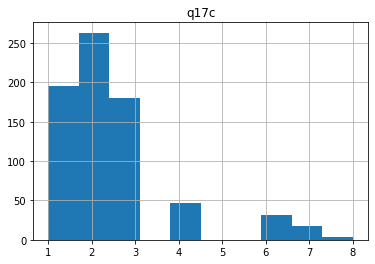

In [91]:
q17txt = pd.read_csv('../data_files/q17_to_categories.txt').set_index('q00')
q17txt.hist()
plt.show()

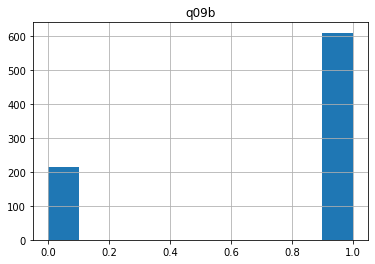

In [92]:
q09txt = pd.read_csv('../data_files/q09_to_categories.txt').set_index('q00')
q09txt.hist()
plt.show()